# Absorption

This section currently focus on the calculation of absorption spectra, with vibrational effects to be added.

In [1]:
import gator
import matplotlib.pyplot as plt
import multipsi as mtp
import numpy as np
import py3Dmol as p3d
import veloxchem as vlx
from matplotlib import gridspec
from scipy.interpolate import interp1d

# au to eV conversion factor
au2ev = 27.211386

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


We here consider the UV/vis spectrum of gaseous water, with molecular structure:

In [2]:
water_xyz = """
O       0.0000000000     0.1178336003     0.0000000000
H      -0.7595754146    -0.4713344012     0.0000000000
H       0.7595754146    -0.4713344012     0.0000000000 
"""

viewer = p3d.view(width=400, height=300)
viewer.setViewStyle({"style": "outline", "color": "black", "width": 0.1})
viewer.addModel("3\n" + water_xyz)
viewer.setStyle({"stick": {}})
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## TDDFT

Calculating the first six eigenstates using TDDFT:

In [3]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_results = scf_drv.compute(molecule, basis)

# resolve four eigenstates
rpa_solver = vlx.lreigensolver.LinearResponseEigenSolver()
rpa_solver.update_settings({"nstates": 6}, method_settings)
rpa_results = rpa_solver.compute(molecule, basis, scf_drv.scf_tensors)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

               Spin-Restricted Kohn-Sham:                                                                                 
               --------------------------                                                                                 
               Total Energy                       :      -76.3851807749 a.u.                                              
               Electronic Energy                  :      -85.5413254944 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000001389 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 6                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

* Info * Processing Fock builds... (batch size: 10)                                                                       
* Info *   batch 1/1                                                                                                      
                                                                                                                          
* Info * 23 gerade trial vectors in reduced space                                                                         
* Info * 23 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 34.22 kB of memory used for subspace procedure on the master node                                                
* Info * 688.29 MB of memory available for the solver on the master node                                                  
                

There are currently no built-in functionalities for obtaining the broadened spectra, so we instead construct this from the eigenvalues and oscillator strengths, as well as printing a table with energies (here in atomic units), oscillator strengths, and transition dipole moments:

```{note}
Broadening and $\sigma$ extraction routines are currently being implemented.
```

Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)
   0.286      0.01128   0.00000  -0.00000   0.24321
   0.364      0.09652  -0.00000   0.63080   0.00000
   0.364      0.00000  -0.00000  -0.00000   0.00000
   0.454      0.08684  -0.53570   0.00000  -0.00000
   0.540      0.41655   1.07524   0.00000  -0.00000
   0.666      0.24377  -0.00000  -0.74073  -0.00000


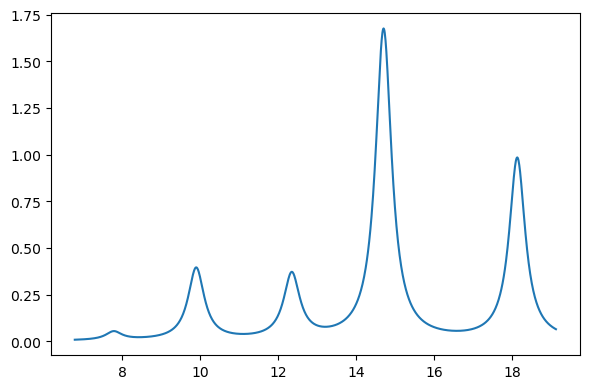

In [4]:
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi


# Print results as a table
print("Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)")
for i in np.arange(len(rpa_results["eigenvalues"])):
    e, os, x, y, z = (
        rpa_results["eigenvalues"][i],
        rpa_results["oscillator_strengths"][i],
        rpa_results["electric_transition_dipoles"][i][0],
        rpa_results["electric_transition_dipoles"][i][1],
        rpa_results["electric_transition_dipoles"][i][2],
    )
    print("   {:.3f}     {:8.5f}  {:8.5f}  {:8.5f}  {:8.5f}".format(e, os, x, y, z))

plt.figure(figsize=(6, 4))
x = au2ev * rpa_results["eigenvalues"]
y = rpa_results["oscillator_strengths"]
xi, yi = lorentzian(x, y, min(x) - 1.0, max(x) + 1.0, 0.01, 0.5)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()

## CPP-DFT

Using CPP-DFT, the linear absorption cross-section is resolved over a range of energies, which is here chosen as the 7-17 eV (with a resolution of 0.1 eV):

```{note}
The frequency specification is currently being rewritten.
```

In [5]:
# Define spectrum region to be resolved
xmin, xmax = 7.0, 17.0
freqs = np.arange(xmin, xmax, 0.1) / au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_drv = vlx.rsplinabscross.LinearAbsorptionCrossSection(
    {"frequencies": ",".join(freqs_str), "damping": 0.3 / au2ev}, method_settings
)
cpp_drv.init_driver()
cpp_results = cpp_drv.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_drv.rsp_property["response_functions"][("x", "x", w)].imag
    ayy = -cpp_drv.rsp_property["response_functions"][("y", "y", w)].imag
    azz = -cpp_drv.rsp_property["response_functions"][("z", "z", w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

                                                                                                                          
                                              Complex Response Solver Setup                                               
                                                                                                                          
                               Number of Frequencies           : 100                                                      
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

* Info * Processing Fock builds... (batch size: 26)                                                                       
* Info *   batch 1/1                                                                                                      
                                                                                                                          
* Info * 25 gerade trial vectors in reduced space                                                                         
* Info * 27 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 598.81 kB of memory used for subspace procedure on the master node                                               
* Info * 686.84 MB of memory available for the solver on the master node                                                  
                

* Info * Processing Fock builds... (batch size: 59)                                                                       
* Info *   batch 1/1                                                                                                      
                                                                                                                          
* Info * 32 gerade trial vectors in reduced space                                                                         
* Info * 79 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 637.73 kB of memory used for subspace procedure on the master node                                               
* Info * 692.91 MB of memory available for the solver on the master node                                                  
                

* Info * Processing Fock builds... (batch size: 2)                                                                        
* Info *   batch 1/1                                                                                                      
                                                                                                                          
* Info * 33 gerade trial vectors in reduced space                                                                         
* Info * 80 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 637.85 kB of memory used for subspace procedure on the master node                                               
* Info * 681.03 MB of memory available for the solver on the master node                                                  
                

Plotting the raw output, the raw output with a splined function, and a comparison to the eigenstate results above (here plotted as bars):

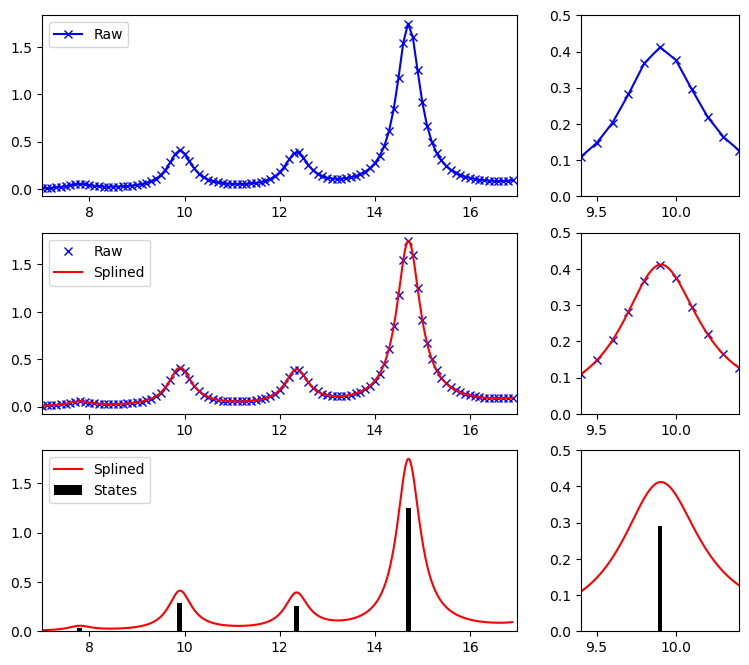

In [6]:
# Make figure with panels of 3:1 width
plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1])

# Raw results for the full region
plt.subplot(gs[0])
plt.plot(au2ev * freqs, sigma, "bx-")
plt.legend(("Raw", ""), loc="upper left")
plt.xlim((xmin, xmax))

# Raw results for a zoomed in region
plt.subplot(gs[1])
plt.plot(au2ev * freqs, sigma, "bx-")
plt.xlim((9.4, 10.4))
plt.ylim((0, 0.50))

# Raw and splined spectra for the full region
plt.subplot(gs[2])
plt.plot(au2ev * freqs, sigma, "bx")
x = np.arange(min(au2ev * freqs), max(au2ev * freqs), 0.01)
y = interp1d(au2ev * freqs, sigma, kind="cubic")
plt.plot(x, y(x), "r")
plt.legend(("Raw", "Splined"), loc="upper left")
plt.xlim((xmin, xmax))

# Zoomed in raw and splined spectra
plt.subplot(gs[3])
plt.plot(au2ev * freqs, sigma, "bx")
plt.plot(x, y(x), "r")
plt.xlim((9.4, 10.4))
plt.ylim((0, 0.50))

# Zoomed in raw and splined spectra for the full region
plt.subplot(gs[4])
x = np.arange(min(au2ev * freqs), max(au2ev * freqs), 0.01)
y = interp1d(au2ev * freqs, sigma, kind="cubic")
plt.plot(x, y(x), "r")
xi = au2ev * rpa_results["eigenvalues"]
yi = rpa_results["oscillator_strengths"]
plt.bar(xi, 3.0 * yi, width=0.1, color="k")
plt.legend(("Splined", "States"), loc="upper left")
plt.xlim((xmin, xmax))

# Zoomed in raw and splined spectra
plt.subplot(gs[5])
plt.plot(x, y(x), "r")
plt.bar(xi, 3.0 * yi, width=0.025, color="k")
plt.xlim((9.4, 10.4))
plt.ylim((0, 0.50))

plt.show()

(sec:adc-absorp)=
## ADC

The first six excited states of water is calculated as:

In [7]:
# Construct structure and basis objects
molecule = gator.get_molecule(water_xyz)
basis = gator.get_molecular_basis(molecule, "6-31G")

# Perform SCF calculation
scf_gs = gator.run_scf(molecule, basis)

# Calculate the 6 lowest eigenstates
adc_results = gator.run_adc(molecule, basis, scf_gs, method="adc3", singlets=6)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

SCF converged in 4 iterations.
Total Energy: -75.9838703758 au
Starting adc3 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    12       0.15686  265ms  [0.39139529 0.47650984 0.49094138 0.57574508 0.62906502 0.76698694]
  2    24     0.0079564  562ms  [0.31545297 0.39679964 0.40998243 0.4970394  0.56884827 0.70198492]
  3    36    0.00056412  489ms  [0.3128226  0.39358839 0.40590815 0.49200391 0.56576577 0.69812217]
  4    48    6.6388e-05  694ms  [0.31271795 0.3934001  0.40568027 0.49168013 0.5655336  0.69778162]
  5    60    1.1005e-05  842ms  [0.31271345 0.39338801 0.4056698  0.49165875 0.56551124 0.69772592]
=== Restart ===
  6    24    2.2941e-06  599ms  [0.31271337 0.39338773 0.40566941 0.49165799 0.56550977 0.69771712]
  7    36    5.5272e-07  672ms  [0.31271337 0.39338772 0.40566937 0.49165793 0.56550957 0.69771518]
=== Converged ===
    Number of matrix applies:    84
    Total solver time:             4s 155ms


The resuls can be printed as a table, and convoluted and plotted using built-in functionalities (which can use several different energy-axis, as shown below).

```{note}
The `adc3 (adc2)` designation from `adc_results.describe()` means that *energies* are calculated at an ADC(3) level, while *properties* are given at an ADC(2) level. This is sometimes referred to as ADC(3/2), as well.
```

+--------------------------------------------------------------+
| adc3 (adc2)                             singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0     0.3127134      8.509364   0.0134     0.951   0.04895  |
|  1     0.3933877      10.70463   0.0000    0.9532   0.04681  |
|  2     0.4056694      11.03883   0.1161    0.9491   0.05091  |
|  3     0.4916579      13.37869   0.1103     0.949   0.05096  |
|  4     0.5655096       15.3883   0.4351    0.9625   0.03751  |
|  5     0.6977152       18.9858   0.2604    0.9537   0.04626  |
+--------------------------------------------------------------+



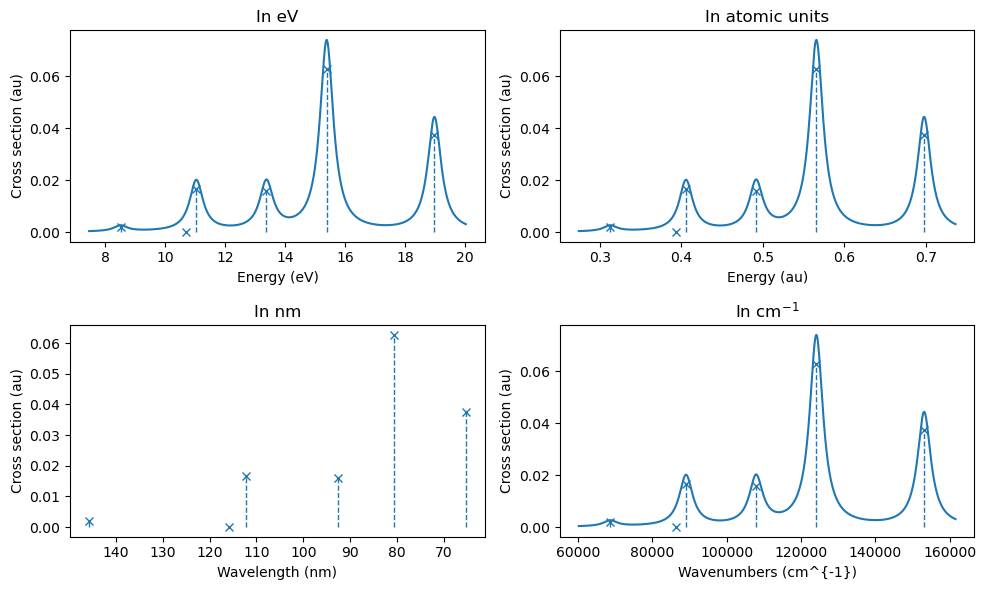

In [8]:
# Print information on eigenstates
print(adc_results.describe())

# Plot using built-in functionalities
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.title("In eV")
adc_results.plot_spectrum(xaxis="eV")

plt.subplot(222)
plt.title("In atomic units")
adc_results.plot_spectrum(xaxis="au")

plt.subplot(223)
plt.title("In nm")
adc_results.plot_spectrum(xaxis="nm", broadening=None)

plt.subplot(224)
plt.title(r"In cm$^{-1}$")
adc_results.plot_spectrum(xaxis="cm-1")
plt.tight_layout()
plt.show()

> Fix: broaden spectra expressed in wavelength.

Note that some high-energy features can be the result of a discretized continuum region. A larger basis set will flatten out this region, but care should be taken for any analysis of that part of the spectrum.

## CPP-ADC

> To be added.

## MCSCF

In some cases, it can be preferable to use a multiconfigurational wavefunction to compute excitation energies. This is necessary if, for instance, the molecule is suspected to have strong correlation effects, or if the user is interested in analyzing a conical intersection --- something that ADC and TDDFT often fail to properly describe.

In principle, a MCSCF spectrum can be computed using response theory similarly to ADC and DFT. However, as configuration interaction (CI) can naturally provide not just the lowest but any state, it is possible to produce excited states by simply increasing the number of requested states or "roots" in the CI. However, in traditional MCSCF, the orbitals cannot be simultaneously optimized for each state, and instead we use a set of orbitals that is a compromise between all states: the state-averaged orbitals.

For water in its equilibrium distance, there is no strong correlation, and thus the only orbitals we need to include in the active space are those that can be excited in the UV-visible spectrum. Here, we will use a CASSCF with an active space comprising the molecular orbitals formed by the oxygen 2p and hydrogen 1s, corresponding to the two $\sigma$ and $\sigma^*$ and one oxygen lone pair. We could in principle include the other lone pair, formed mostly by the 2s orbital of the oxygen, but its orbital energy is much lower and the orbital is thus not involved in the lowest UV-visible transitions.

The orbitals are conveniently located around the HOMO-LUMO gap, so it is sufficient to request a CAS(6,5) (6 electrons in 5 orbitals) to get the desired active space. First, we calculate the SCF ground state:

In [9]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF calculation
scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

Then we resolve the six lowest excited states:

In [10]:
# Active space settings
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.cas(6, 5)  # 3 O_2p and 2 H_1s

# CASSCF calculation
mcscf_drv = mtp.McscfDriver()
mcscf_results = mcscf_drv.compute(molecule, basis, space, 6)

# Transition properties
SI = mtp.InterState()
DipOsc = SI.compute(molecule, basis, mcscf_results)

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-averaged calculation
            Number of states      : 6
            Equal-weights 
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                                     

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.58548         1.220154e-02    2.799323e-02
     1       4       10.35559         1.097824e-01    1.281782e-01
     1       5       12.59261         1.545527e-01    1.469866e-01
     1       6       14.56080         5.993590e-01    3.307423e-01
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cg

The resulting states are printed above, or can be printed or plotted:

Energy [au]  Osc. str.
   0.279      0.01220
   0.362      0.00000
   0.381      0.10978
   0.463      0.15455
   0.535      0.59936


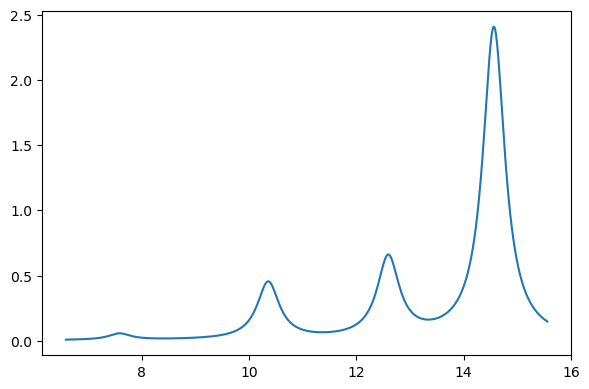

In [11]:
# Print results as a table
print("Energy [au]  Osc. str.")
for i in np.arange(len(DipOsc["energies"])):
    e, os = (
        DipOsc["energies"][i],
        DipOsc["oscillator_strengths"][i],
    )
    print("   {:.3f}     {:8.5f}".format(e, os))

plt.figure(figsize=(6, 4))
x = au2ev * DipOsc["energies"]
y = DipOsc["oscillator_strengths"]
xi, yi = lorentzian(x, y, min(x) - 1.0, max(x) + 1.0, 0.01, 0.5)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()

Comparing to ADC(3) we see a good agreement in relative features, but the absolute energies and intensities are a bit different:

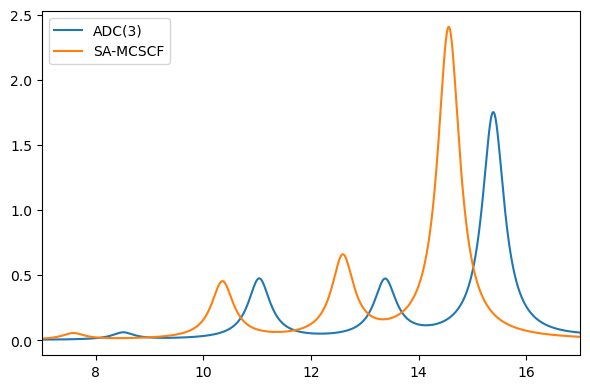

In [12]:
plt.figure(figsize=(6, 4))

# ADC(3)
x, y = au2ev * adc_results.excitation_energy, adc_results.oscillator_strength
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)
plt.plot(xi, yi)

# SA-MCSCF
x = au2ev * DipOsc["energies"]
y = DipOsc["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)
plt.plot(xi, yi)
plt.legend(("ADC(3)", "SA-MCSCF"))
plt.xlim((xmin, xmax))
plt.tight_layout()
plt.show()

As an alternative to using state-averaging, we can also use linear response CASSCF. One advantage in this case is that we do not need to add the oxygen lone pair in the active space, since the response includes also excitation outside of the active space. Let's try it:

In [13]:
# Active space settings
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)

# The list of active orbitals, orbital 4 is not here since it is the lone pair
space.cas_orbitals([2, 3, 5, 6])

# CASSCF calculation
mcscf_drv = mtp.McscfDriver()
mcscf_results = mcscf_drv.compute(molecule, basis, space)  # Only ground state

# Response calculation
mcrpa = mtp.Mclr_EigenSolver()
rspdict = mcrpa.compute(molecule, basis, mcscf_drv, 5)

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-specific calculation
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                                                                          

          Active space def

Warning, significant negative value in orbital S(2): -0.20346852007551353
                                                                                                                          
Initialization time: 00:00:00
                                                                                                                          
          Linear eigensolver
          ------------------
                                                                                                                          
CI parameters:      20
Orbital parameters: 54
                                                                                                                          
                                                                                                                          
                                                                                                                          
        MC-RPA Iterations
        -----------------
  

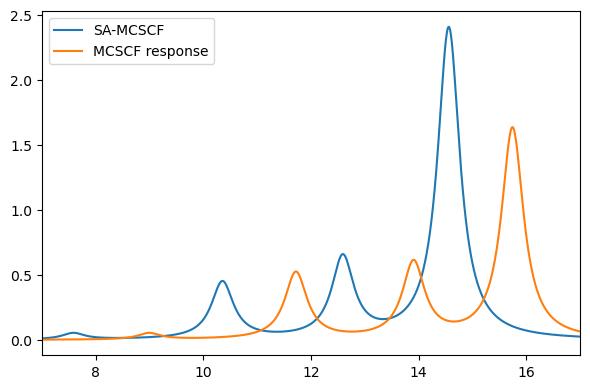

In [14]:
plt.figure(figsize=(6, 4))
xmin, xmax = 7, 17

# SA-MCSCF
x = au2ev * DipOsc["energies"]
y = DipOsc["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)
plt.plot(xi, yi)

# MCSCF response
x = au2ev * rspdict["eigenvalues"]
y = rspdict["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)

plt.plot(xi, yi)
plt.legend(("SA-MCSCF", "MCSCF response"))
plt.xlim((xmin, xmax))
plt.tight_layout()
plt.show()

## Comparison of spectra

The spectra from the four different approaches can be plotted as:

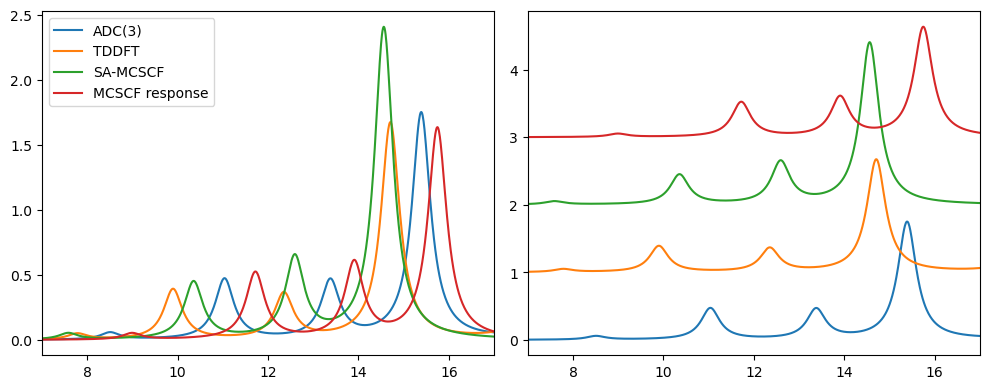

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)

xmin, xmax = 7, 17

# ADC(3)
x, y = au2ev * adc_results.excitation_energy, adc_results.oscillator_strength
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)
ax1.plot(xi, yi)
ax2.plot(xi, yi)

# TDDFT
x = au2ev * rpa_results["eigenvalues"]
y = rpa_results["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)
ax1.plot(xi, yi)
ax2.plot(xi, yi + 1)

# SA-MCSCF
x = au2ev * DipOsc["energies"]
y = DipOsc["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)
ax1.plot(xi, yi)
ax2.plot(xi, yi + 2)

# MCSCF response
x = au2ev * rspdict["eigenvalues"]
y = rspdict["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin, xmax, 0.01, 0.5)
ax1.plot(xi, yi)
ax2.plot(xi, yi + 3)

ax1.legend(("ADC(3)", "TDDFT", "SA-MCSCF", "MCSCF response"))
ax1.set_xlim((xmin, xmax))
ax2.set_xlim((xmin, xmax))
plt.tight_layout()
plt.show()

Plotted either on top of each other, or with a vertical set-off. We note that the features are, in general, similar, with differences mainly taking the form of absolute energy shifts, as well as noticeably more intense features for SA-MCSCF.